# Spherical ICET

In [1]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp

physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
    
%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

Autosaving every 180 seconds


In [46]:
from ICET_spherical import ICET

# init KITTI dataset -----------------------------------------------------------------
basedir = 'C:/kitti/'
date = '2011_09_26'
drive = '0005'
idx = 10
frame_range = range(150, 151, 1)
dataset = pykitti.raw(basedir, date, drive)
velo1 = dataset.get_velo(idx) # Each scan is a Nx4 array of [x,y,z,reflectance]
c1 = velo1[:,:3]
# c1 = c1[c1[:,2] > -1.5] #ignore ground plane
velo2 = dataset.get_velo(idx+1) # Each scan is a Nx4 array of [x,y,z,reflectance]
c2 = velo2[:,:3]
# c2 = c2[c2[:,2] > -1.5] #ignore ground plane
# ------------------------------------------------------------------------------------

# ## load custom point cloud geneated in matlab------------------------------------------
# c1 = np.loadtxt("scene1_scan1.txt", dtype = float)
# # c2 = c1 + np.array([2.0, 0.2, 0])
# c2 = c1 + np.array([0.1, 0., 0.])

# # c1 = c1[c1[:,2] > -1.5] #ignore ground plane
# # c2 = c2[c2[:,2] > -1.5] #ignore ground plane
# ## ------------------------------------------------------------------------------------

# #single distinct cluster---------------------------------------------------------------
# c1 = np.random.randn(3000,3)*tf.constant([0.04,0.3,0.3]) + tf.constant([6.,0.,0.])
# c2 = np.random.randn(3000,3)*tf.constant([0.04,0.3,0.3]) + tf.constant([6.,0.,0.]) - np.array([0., 0.25, 0.0])
# # # c2 = c1 - np.array([0.1, 0.3, 0.0])
# # -------------------------------------------------------------------------------------

D = True
# D = False
X = tf.constant([0., 0., 0., 0., 0., 0.])
it = ICET(cloud1 = c1, cloud2 = c2,  fid = 30, draw = D, x0 = X, niter = 1, group= 2)
# print(it.grid[(it.fid_theta*(it.fid_phi)):(it.fid_theta*(it.fid_phi))+20])
ViewInteractiveWidget(it.plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

## Identify Useful Clusters

In [ ]:
import matplotlib.pyplot as plt
from utils import get_cluster

#index of spike that each of the points from cloud 1 is occupying
print(it.bins_spike)

occupied_spikes, idxs = tf.unique(it.bins_spike)
print("\n occupied_spikes \n", occupied_spikes)
temp =  tf.where(it.bins_spike == occupied_spikes[:,None])
rag = tf.RaggedTensor.from_value_rowids(temp[:,1], temp[:,0])
idx_by_rag = tf.gather(it.cloud1_tensor_spherical[:,0], rag)

# rads = idx_by_rag[50,:] #single element from ragged tensor
# rads = tf.transpose(idx_by_rag.to_tensor()[15:20,:])
rads = tf.transpose(idx_by_rag.to_tensor())
# print(rads) #starts out unordered

# #_________________________________________________________________
fig, ax = plt.subplots(2,1)
nbins = 25
ax[0].hist(rads.numpy(), nbins, histtype = 'step');
yax = tf.ones(tf.shape(rads), tf.float32) #plots everything on top of eachother
yax = yax * tf.cast(tf.linspace(1, 0, tf.shape(rads)[1]), tf.float32)
# print(tf.linspace(0, 1, tf.shape(rads)[1])[:,None] )
ax[1].plot(rads,yax, 'b.', markersize = 3)
# #_________________________________________________________________
""
bounds = get_cluster(rads)
print("\n Bounds \n", bounds)


In [ ]:
a = np.zeros([1,2])
b = np.ones([3,2])
print(np.append(b, a, axis = 0))

In [ ]:
edges_r = bounds[6,:]
print(edges_r)
pts = tf.cast(tf.convert_to_tensor(c1[:,1]), tf.float64)
print(pts)

bins_r = tfp.stats.find_bins(pts, edges_r)
print(bins_r)
#get rid of NaNs
nonnan = 1 - tf.cast(tf.math.is_nan(bins_r), tf.float32)
idxnonan = tf.where(nonnan == 1)
print(tf.gather(bins_r, idxnonan))

In [24]:
#get true transformation between frames
from metpy.calc import lat_lon_grid_deltas
poses0 = dataset.oxts[idx] #<- ID of 1st scan
poses1 = dataset.oxts[idx+1] #<- ID of 2nd scan
lat0 = poses0.packet.lat
lon0 = poses0.packet.lon
alt0 = poses0.packet.alt
lat1 = poses1.packet.lat
lon1 = poses1.packet.lon
alt1 = poses1.packet.alt

dx_oxts, dy_oxts = lat_lon_grid_deltas(np.array([lon0,lon1]), np.array([lat0, lat1]))
# print(dx_oxts, dy_oxts) 
dx_oxts = dx_oxts[0,0].magnitude
dy_oxts = dy_oxts[0,0].magnitude
dz_oxts = (alt0-alt1)
droll_oxts = (poses0.packet.roll - poses1.packet.roll)
dpitch_oxts = (poses0.packet.pitch - poses1.packet.pitch)
dyaw_oxts = (poses0.packet.yaw - poses1.packet.yaw)

rot = poses1.T_w_imu[:3,:3] #trying this

dxyz_oxts = np.array([[dx_oxts, dy_oxts, dz_oxts]])
dxyz_lidar = dxyz_oxts.dot(rot)
print(dxyz_lidar)

dt = 0.10
from_vel = np.array([[poses1.packet.vf*dt, poses1.packet.vl*dt, poses1.packet.vu*dt, -poses1.packet.wf*dt, -poses1.packet.wl*dt, -poses1.packet.wu*dt]])
print(from_vel)


[[ 0.30123163 -0.02423234  0.00349136]]
[[ 0.31619813  0.00952271 -0.01318738 -0.00226272  0.00075722 -0.01186753]]


In [ ]:
#test batch rotation matrix conversions
from utils import R_tf

print(R_tf(tf.Variable([[0., 0., 1.]])), "\n")

angs = tf.Variable([[0., 0., 1.], [0., 0., 1.]])
# angs = tf.Variable([[0., 0., 1.]])
print(angs)

rots = R_tf(angs)
print(rots)


In [ ]:
#pad tensors to get them to the same length
#to fix bug in get_U_and_L()

t1 = tf.ones([8,3], tf.int32)
print(t1)
t2 = tf.ones([7,3], tf.int32)
print(t2)

bofa = tf.sets.intersection(t1, t2).values

In [ ]:
#test- workaround for in place tensor operations
indices = tf.cast(tf.constant([1, 2, 3, 5]), tf.int32)[:,None]
print("indices", indices)
updates = tf.ones(tf.shape(indices))
print("updates", updates)
shape = tf.constant([7, 1])
print("shape", shape)

b = tf.scatter_nd(indices, updates, shape)
print(b)


## Plot results of ICET estimates on KITTI lidar point clouds vs GPS/INS baseline

<IPython.core.display.Javascript object>


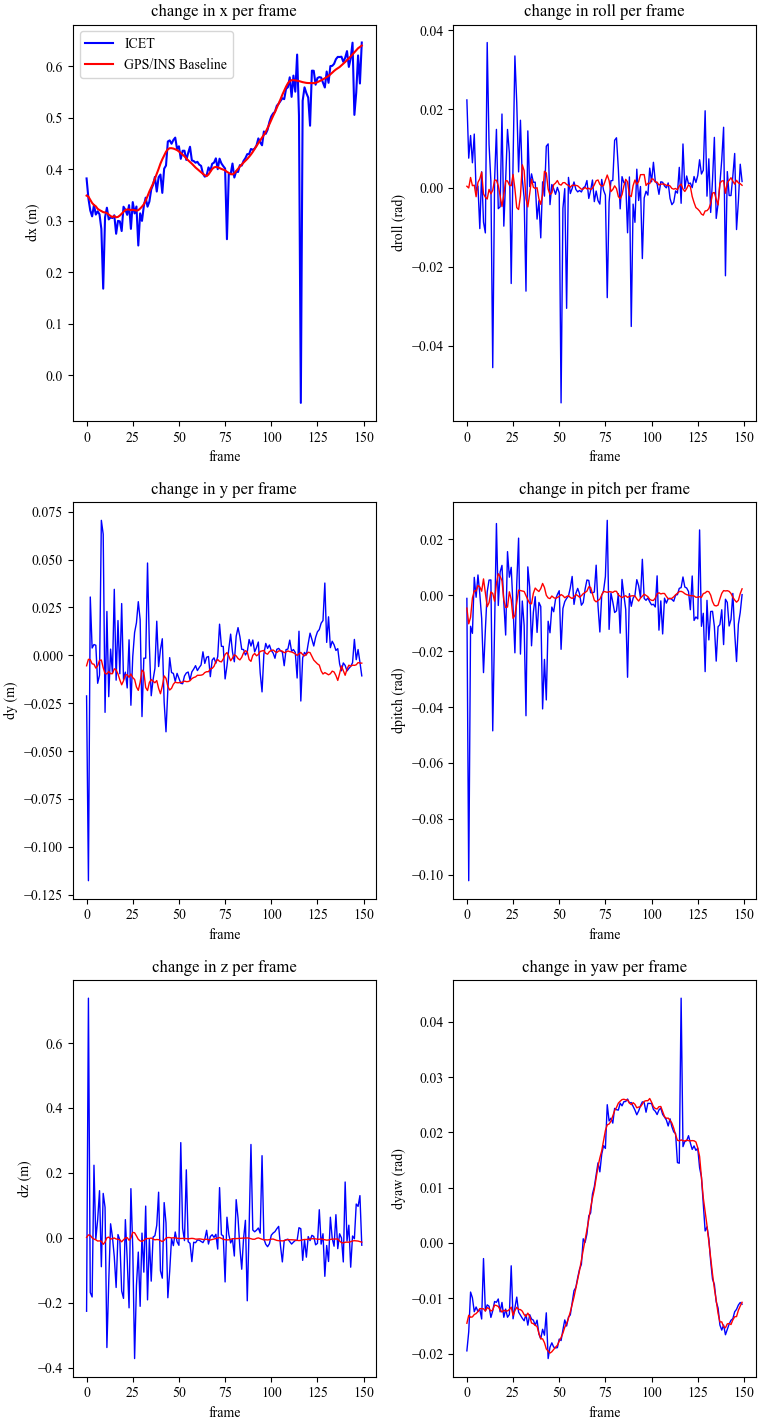

In [32]:
import matplotlib.pyplot as plt
font = {'fontname':'Times New Roman'}

OXTS_baseline = np.loadtxt("OXTS_baseline_v3.txt")
ICET_estimates = np.loadtxt("ICET_estimates_v3.txt")

OXTS_baseline[:,3:] = OXTS_baseline[:,3:]/0.1*0.1037

#fix sign errors
ICET_estimates[:,1] = -ICET_estimates[:,1]
ICET_estimates[:,3:] = -ICET_estimates[:,3:]
style1 = 'b-'
style2 = 'r-'

fig, ax = plt.subplots(3,2, constrained_layout = True)
ax[0,0].plot(ICET_estimates[:,0], style1, label = 'ICET')
ax[0,0].plot(OXTS_baseline[:,0], style2, label = 'GPS/INS Baseline')
# ax[0,0].plot(np.arange(n//2, np.shape(ICET_estimates)[0] - n//2 ), moving_avg(OXTS_baseline[:,0], n),  style2, label = 'GPS/INS Baseline')
# ax[0,0].plot(np.arange(n//2, np.shape(ICET_estimates)[0] - n//2 ), moving_avg(ICET_estimates[:,0], n),  style1, label = 'GPS/INS Baseline')
ax[0,0].set_title("change in x per frame", **font)
ax[0,0].set_ylabel("dx (m)", **font)
ax[0,0].legend(loc = 'upper left')
ax[0,0].set_xlabel("frame", **font)

ax[1,0].plot(ICET_estimates[:,1], style1, lw = 1)
ax[1,0].plot(-OXTS_baseline[:,1], style2, lw = 1)
# ax[1,0].plot(np.arange(n//2, np.shape(ICET_estimates)[0] - n//2 ), moving_avg(OXTS_baseline[:,1], n),  style2, lw = 1)
ax[1,0].set_title("change in y per frame", **font)
ax[1,0].set_ylabel("dy (m)", **font)
ax[1,0].set_xlabel("frame", **font)


ax[2,0].plot(ICET_estimates[:,2], style1, lw = 1)
ax[2,0].plot(OXTS_baseline[:,2], style2, lw = 1)
# ax[2,0].plot(np.arange(n//2, np.shape(ICET_estimates)[0] - n//2 ), moving_avg(OXTS_baseline[:,2], n),  style2, lw = 1)
ax[2,0].set_title("change in z per frame", **font)
ax[2,0].set_ylabel("dz (m)", **font)
ax[2,0].set_xlabel("frame", **font)

ax[0,1].plot(ICET_estimates[:,3], style1, lw = 1)
ax[0,1].plot(OXTS_baseline[:,3], style2, lw = 1)
ax[0,1].set_title("change in roll per frame", **font)
ax[0,1].set_ylabel("droll (rad)", **font)
ax[0,1].set_xlabel("frame", **font)


ax[1,1].plot(ICET_estimates[:,4], style1, lw = 1)
ax[1,1].plot(OXTS_baseline[:,4], style2, lw = 1)
ax[1,1].set_title("change in pitch per frame", **font)
ax[1,1].set_ylabel("dpitch (rad)", **font)
ax[1,1].set_xlabel("frame", **font)


ax[2,1].plot(ICET_estimates[:,5], style1, lw = 1)
ax[2,1].plot(OXTS_baseline[:,5], style2, lw = 1)
ax[2,1].set_title("change in yaw per frame", **font)
ax[2,1].set_ylabel("dyaw (rad)", **font)
ax[2,1].set_xlabel("frame", **font)

# fig.tight_layout(h_pad = 0.1)
plt.show()

<IPython.core.display.Javascript object>


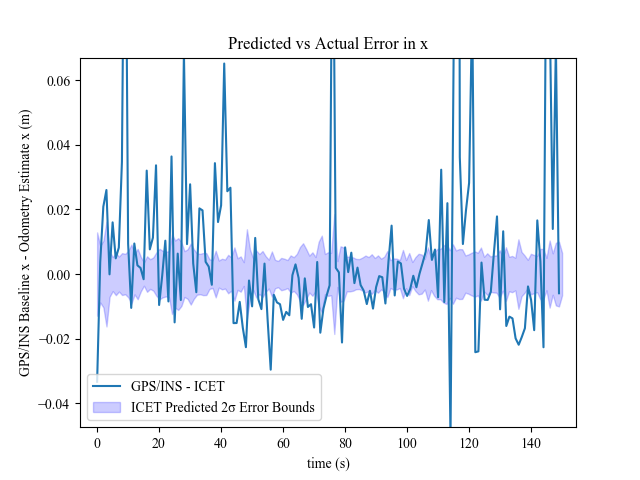

Text(0, 0.5, 'GPS/INS Baseline x - Odometry Estimate x (m)')

In [34]:
#plot error between ICET and absolute position
plt.rc('font',family='Times New Roman')
fig3, ax3 = plt.subplots(1,1)

ICET_pred_stds = np.loadtxt("ICET_pred_stds_v3.txt")

#which component to look at
# c = 5 #yaw
c = 0 # x (forward movement)

diffx = OXTS_baseline[:,c] - ICET_estimates[:,c]
    
#flip sign when looking at yaw
if c ==5:
    diffx = -diffx 
    
cum_err = np.zeros(np.shape(ICET_pred_stds))
cum_diffx = np.zeros(np.shape(diffx))

for i in range(np.shape(ICET_pred_stds)[0]):
    cum_err[i,:] = np.sum(ICET_pred_stds[:i,:]**2, axis = 0)
    #add in baseline OXTS 1-sigma errors
    cum_err[i,:] += np.sqrt(2)*np.array([0.05,0.05,0.1,0.0005,0.0005,0.001])**2
    cum_err[i,:] = np.sqrt(cum_err[i,:]) 
    
for j in range(np.shape(diffx)[0]):
    cum_diffx[j] = np.sum(diffx[:j]) 

# # #old (error for each individual timestep)------------------------
ax3.plot(diffx, label = 'GPS/INS - ICET')
ax3.fill_between(np.linspace(0,150,np.shape(ICET_pred_stds)[0]), -2*ICET_pred_stds[:,c], 2*ICET_pred_stds[:,c], 
                 color = (0,0,1,0.2), label = 'ICET Predicted 2σ Error Bounds')
# # #-------------------------------------------------------------------

# #new (accumulated differences in error)--------------------------
# # ax3.plot(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), cum_diffx_with_ground, label = 'GPS/INS - ICET')
# ax3.plot(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), cum_diffx, label = 'GPS/INS - ICET')
# ax3.fill_between(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), -2*cum_err[:,c], 2*cum_err[:,c], 
#                  color = (0,0,1,0.2), label = 'Predicted 2σ Error Bounds')
#--------------------------------------------------------------------

ax3.legend(loc = 'lower left')
ax3.set_title("Predicted vs Actual Error in x")
ax3.set_xlabel("time (s)", **font)
ax3.set_ylabel("GPS/INS Baseline x - Odometry Estimate x (m)", **font)
# ax3.set_ylim([-0.07,0.07])

In [ ]:
#test where points are inside spherical cell...
# print(it.cloud1_tensor_spherical)
maxtheta = tf.constant([[0.2],[0.7]])
maxr = tf.constant([[0.5],[2.]])

ans1 = tf.greater(it.cloud1_tensor_spherical[:,1], maxtheta)
# print(ans1)
ans2 = tf.less(it.cloud1_tensor_spherical[:,0], maxr)
# print(ans2)
combined = tf.Variable([ans1, ans2])
# print(combined)
ans3 = tf.math.reduce_all(combined, axis = 1)

print(ans3)

In [ ]:
#duplicate each element of an n*1 vector 3 times
t = tf.linspace(0,5,6)[:,None]
print(t)

test  = tf.tile(t, [3,1])
# print(test)
test2 = tf.reshape(tf.transpose(tf.reshape(test, [3,-1])), [-1,1])
print(test2)
test3 = tf.reshape(tf.transpose(tf.reshape(test, [3,-1])), [-1,3])
print(test3)

In [ ]:
#duplicate each element of an n*3 vector 3 times
t = tf.linspace(1,4,4)
t = tf.transpose(tf.Variable([t, 2*t, 3*t]))
print(t)

test  = tf.tile(t, [3,1])
# print(test)

test = tf.reshape(tf.transpose(test), [3, 3, -1])
# print(test)

test = tf.transpose(test, [2,1,0])
# print(test)

test = tf.reshape(test, [-1,3])
print(test)
